In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [4]:
torch.cuda.is_available()

True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
torch.manual_seed(42)

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [8]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [9]:
training_data = CIFAR10(root="cifar", train=True, download=True, transform=transform)
test_data = CIFAR10(root="cifar", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
classes = training_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
batch_size = 24

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"Len of train_dataloader: {len(train_dataloader)}")
print(f"Len of test_dataloader: {len(train_dataloader)}")

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Len of train_dataloader: 2084
Len of test_dataloader: 2084
Shape of X [N, C, H, W]: torch.Size([24, 3, 32, 32])
Shape of y: torch.Size([24]) torch.int64


In [12]:
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.d1 = 0.1
        self.conv1 = nn.Conv2d(3, 48, 3)
        self.conv2 = nn.Conv2d(48, 48, 3)
        self.conv3 = nn.Conv2d(48, 96, 3)
        self.conv4 = nn.Conv2d(96, 96, 3, stride=2)
        self.flat = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(96 * 12 * 12)
        self.fc1 = nn.Linear(96 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.dropout(x, self.d1)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.dropout(x, 0.5)
        x = self.flat(x)
        x = nn.functional.relu(self.batch_norm(x))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet().to(device)

In [13]:
# Trian Method
def train(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose == True:
            if batch % 50 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    return loss

In [14]:
# Test Method
def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose == True:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct # For reporting tuning results/ early stopping

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-----------------------------------
loss: 2.295671 [    0/50000]
loss: 1.950296 [ 1200/50000]
loss: 1.740581 [ 2400/50000]
loss: 1.828866 [ 3600/50000]
loss: 1.670691 [ 4800/50000]
loss: 1.633000 [ 6000/50000]
loss: 1.726688 [ 7200/50000]
loss: 1.583476 [ 8400/50000]
loss: 1.481822 [ 9600/50000]
loss: 1.546372 [10800/50000]
loss: 1.837430 [12000/50000]
loss: 1.873442 [13200/50000]
loss: 1.681345 [14400/50000]
loss: 1.530679 [15600/50000]
loss: 1.883100 [16800/50000]
loss: 1.416780 [18000/50000]
loss: 1.098042 [19200/50000]
loss: 1.626524 [20400/50000]
loss: 1.240757 [21600/50000]
loss: 1.347698 [22800/50000]
loss: 1.492997 [24000/50000]
loss: 1.440102 [25200/50000]
loss: 1.519120 [26400/50000]
loss: 1.357719 [27600/50000]
loss: 1.420723 [28800/50000]
loss: 1.337458 [30000/50000]
loss: 1.224036 [31200/50000]
loss: 1.247604 [32400/50000]
loss: 1.510388 [33600/50000]
loss: 1.140653 [34800/50000]
loss: 1.571785 [36000/50000]
loss: 1.443889 [37200/50000]
loss: 1.399976 [38400/50000]

In [17]:
# 可视化滤波器
def visualizeTensor(tensor, ch=0, all_kernels=False, nrow=8, padding=1):
    n, c, w, h = tensor.shape

    if all_kernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    grid = grid.cpu()
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

torch.Size([48, 3, 3, 3])


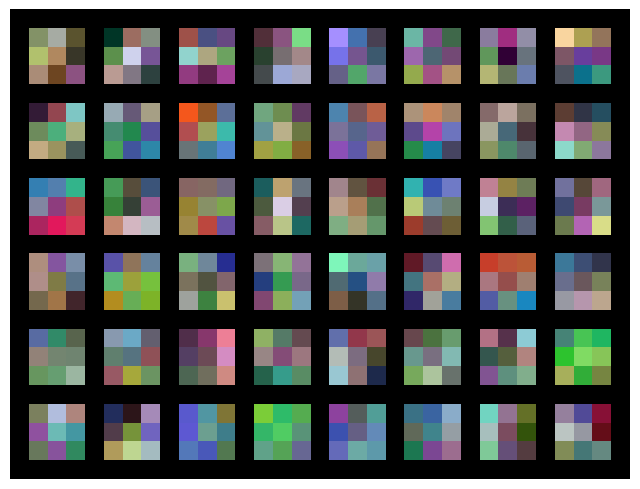

In [20]:
filter = model.conv1.weight.data.clone()
print(filter.shape)
visualizeTensor(filter)
plt.axis('off')
plt.ioff()
plt.show()

In [21]:
# 超参数优化
class ConfigNet(nn.Module):
    def __init__(self, l1=256, c1=48, c2=96, d1=0.1) -> None:
        super().__init__()
        self.d1 = d1
        self.conv1 = nn.Conv2d(3, c1, 3)
        self.conv2 = nn.Conv2d(c1, c1, 3)
        self.conv3 = nn.Conv2d(c1, c2, 3)
        self.conv4 = nn.Conv2d(c2, c2, 3, stride=2)
        self.flat = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(c2 * 144)
        self.fc1 = nn.Linear(c2 *144, l1)
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.dropout(x, self.d1)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.dropout(x, 0.5)
        x = self.flat(x)
        x = nn.functional.relu(self.batch_norm(x))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConfigNet().to(device)

In [22]:
# define search space
search_space = {
    'c1': [48, 96],
    'c2': [96, 192],
    'l1': [256, 512],
}

best_results = {
    'c1': None,
    'c2': None,
    'l1': None, 
    'loss': None,
    'acc': 0
}

In [30]:
# self.verbose = True 记录控制台的更新
class EarlyStopping():
    def __init__(self, tolerance=5, verbose=False, path="cifar-tune.pth") -> None:
        self.tolerance = tolerance
        self.counter = 0
        self.early_stop = False
        self.lowest_loss = None
        self.verbose = verbose
        self.path = path

    def step(self, val_loss):
        if(self.lowest_loss == None):
            self.lowest_loss = val_loss
            torch.save(model.state_dict(), self.path)
        elif(val_loss < self.lowest_loss):
            self.lowest_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            if self.verbose:
                print("Early stop counter: {}".format(self.counter + 1))
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping executed.')


In [31]:
# Augment Images for the train set
augmented = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Standard transformation for validation set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = CIFAR10(root="cifar", train=True, download=True, transform=augmented)
test_data = CIFAR10(root="cifar", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
class HyperSearch():
    def __init__(self, config, verbose=True) -> None:
        self.config = config
        self.verbose = verbose
        self.report_list = []
        self.best_results = { 
            'c1': None,
            'c2': None,
            'l1': None,
            'loss': None,
            'acc': 0
            # 'd1': None,
            # 'lr': None,
            # 'bsz': None,
        }

    # Optimization Method
    def optimize(self):
        for l1 in self.config['l1']:
            for c1 in self.config['c1']:
                for c2 in self.config['c2']:
                    early_stopping = EarlyStopping(tolerance=3, verbose=False, path="{}-{}-{}.pth".format(c1, c2, l1))

                    if self.verbose == True:
                        print('Conv1: {} | Conv2: {} | Lin1: {}'.format(str(c1), str(c2), str(l1)))
                    model = ConfigNet(l1=l1, c1=c1, c2=c2).to(device)

                    loss_fn = nn.CrossEntropyLoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

                    train_dataloader = DataLoader(training_data, batch_size=batch_sz, shuffle=True, num_workers=0)
                    test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=True, num_workers=0)

                    epochs = 10
                    for t in range(epochs):
                        if self.verbose == True:
                            print(f"Epoch {t+1}\n-------------------------------")
                        train_loss = train(train_dataloader, model, loss_fn, optimizer, verbose=self.verbose)
                        test_loss, test_acc = test(test_dataloader, model, loss_fn, verbose=self.verbose)

                        # Early Stopping
                        early_stopping.step(test_loss)
                        if early_stopping.early_stop:
                            break
                    print("Done!")
                    self.append_to_report(test_acc, test_loss, c1, c2, l1)

                    if self.best_results['loss'] == None or test_loss < self.best_results['loss']:
                        if self.verbose == True:
                            print("UPDATE: Best loss changed from {} to {}".format(self.best_results['loss'], test_loss))
                        self.best_results.update({
                            'c1': c1,
                            'c2': c2,
                            'loss': test_loss,
                            'l1': l1,
                            'acc': test_acc
                        })
        self.report()
    
    def report(self):
        print("""
|-----------------------------------------------------------------------------------------------------|
|                                                                                                     |
|                              Report for hyperparameter optimization                                 |
|                                                                                                     |
|-----------------------------------------------------------------------------------------------------|
|    RUN     |              PERFORMANCE             |                   CONFIGURATION                 |
|------------|--------------------------------------|-------------------------------------------------|""")
        for idx, item in enumerate(self.report_list):
            print("|   Run {:02d}   |  Accuracy: {:.2f}%   |   Loss: {:.2f}   |  Conv-1: {}  |  Conv-2: {:3}  |  Linear-1: {:>4}  |".format(idx,
                                                                                                                                       item[0]*100,
                                                                                                                                       item[1],
                                                                                                                                       item[2],
                                                                                                                                       item[3],
                                                                                                                                       item[4]))
            print("|------------|---------------------|----------------|--------------|---------------|------------------|")
        print("\nBest Results | Accuracy: {:.2f}%  |  Loss: {:.2f}  |  Conv-1: {}   |  Conv-2: {}  |  Linear-1: {:>4}  |".format(self.best_results['acc']*100,
                                                                                                                                              self.best_results['loss'],
                                                                                                                                              self.best_results['c1'],
                                                                                                                                              self.best_results['c2'],
                                                                                                                                              self.best_results['l1']))
        
    def append_to_report(self, acc, loss, c1, c2, l1):
        list_set = (acc, loss, c1, c2, l1)
        self.report_list.append(list_set)
    

In [33]:
torch.cuda.is_available()

True

In [34]:
%%time

lrate = 0.001
batch_sz = 512

hyper_search = HyperSearch(search_space, verbose=True)

hyper_search.optimize()

Conv1: 48 | Conv2: 96 | Lin1: 256
Epoch 1
-------------------------------
loss: 2.319779 [    0/50000]
loss: 1.603976 [25600/50000]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.395908 

Epoch 2
-------------------------------
loss: 1.400799 [    0/50000]
loss: 1.311279 [25600/50000]
Test Error: 
 Accuracy: 57.5%, Avg loss: 1.200172 

Epoch 3
-------------------------------
loss: 1.260460 [    0/50000]
loss: 1.179457 [25600/50000]
Test Error: 
 Accuracy: 60.8%, Avg loss: 1.104667 

Epoch 4
-------------------------------
loss: 1.108037 [    0/50000]
loss: 1.104411 [25600/50000]
Test Error: 
 Accuracy: 60.1%, Avg loss: 1.150125 

Epoch 5
-------------------------------
loss: 1.134016 [    0/50000]
loss: 1.037136 [25600/50000]
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.058138 

Epoch 6
-------------------------------
loss: 1.046843 [    0/50000]
loss: 1.041521 [25600/50000]
Test Error: 
 Accuracy: 65.1%, Avg loss: 0.994328 

Epoch 7
-------------------------------
loss: 0.905355 [    0/5000

In [35]:
class ConfigNet(nn.Module):
    def __init__(self, l1=256, c1=48, c2=96, d1=0.1) -> None:
        super().__init__()
        self.d1 = d1
        self.conv1 = nn.Conv2d(3, c1, 3)
        self.conv2 = nn.Conv2d(c1, c1, 3)
        self.conv3 = nn.Conv2d(c1, c2, 3)
        self.conv4 = nn.Conv2d(c2, c2, 3, stride=2)
        self.flat = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(c2 * 144)
        self.fc1 = nn.Linear(c2 * 144, l1)
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.dropout(x, self.d1)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.dropout(x, 0.5)
        x = self.flat(x)
        x = nn.functional.relu(self.batch_norm(x))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConfigNet().to(device)

model = ConfigNet(l1=256, c1=48, c2=96, d1=0.1).to(device)
batch_sz = 512
lrate = 0.0008

In [36]:
%%time
early_stopping = EarlyStopping(tolerance=6, verbose=True, path="cifar-optimized-test.pth")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

train_dataloader = DataLoader(training_data, batch_size=batch_sz, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=True, num_workers=0)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)

    # Early Stopping
    early_stopping.step(test_loss)
    if early_stopping.early_stop:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 2.311456 [    0/50000]
loss: 1.550400 [25600/50000]
Test Error: 
 Accuracy: 48.5%, Avg loss: 1.415505 

Epoch 2
-------------------------------
loss: 1.404778 [    0/50000]
loss: 1.267807 [25600/50000]
Test Error: 
 Accuracy: 58.7%, Avg loss: 1.167055 

Epoch 3
-------------------------------
loss: 1.173683 [    0/50000]
loss: 1.092180 [25600/50000]
Test Error: 
 Accuracy: 60.9%, Avg loss: 1.097409 

Epoch 4
-------------------------------
loss: 1.094899 [    0/50000]
loss: 0.996204 [25600/50000]
Test Error: 
 Accuracy: 64.8%, Avg loss: 1.007419 

Epoch 5
-------------------------------
loss: 0.969546 [    0/50000]
loss: 0.962991 [25600/50000]
Test Error: 
 Accuracy: 66.9%, Avg loss: 0.944462 

Epoch 6
-------------------------------
loss: 0.965978 [    0/50000]
loss: 0.880459 [25600/50000]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.930238 

Epoch 7
-------------------------------
loss: 0.865996 [    0/50000]
loss: 0.956678 [25600/50000]
Te

In [37]:
# 模型评估
model = ConfigNet(l1=256, c1=48, c2=96, d1=0.1).to(device)
model.load_state_dict(torch.load("cifar-optimized-test.pth"))

loss_fn = nn.CrossEntropyLoss()
batch_sz = 512

test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=False, num_workers=0)
classes = test_data.classes
test_loss, test_acc = test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 75.9%, Avg loss: 0.699729 



In [38]:
# Accuracy in each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')
    

Accuracy for class airplane: 76.4%
Accuracy for class automobile: 88.6%
Accuracy for class bird : 67.2%
Accuracy for class cat  : 57.1%
Accuracy for class deer : 75.3%
Accuracy for class dog  : 61.5%
Accuracy for class frog : 81.2%
Accuracy for class horse: 81.6%
Accuracy for class ship : 85.6%
Accuracy for class truck: 83.2%


In [39]:
# 混淆矩阵
num_classes = 10

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

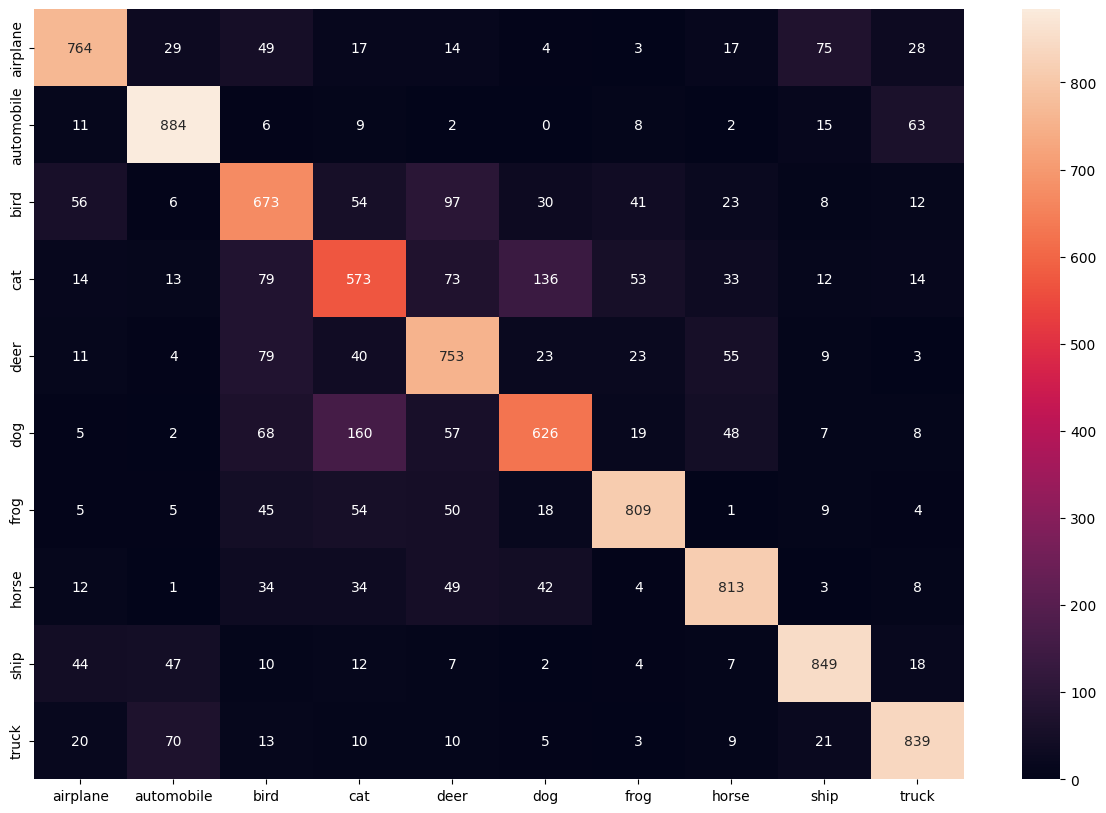

In [42]:
plt.figure(figsize=(15, 10))
cf_dataframe = pd.DataFrame(np.array(confusion_matrix, dtype='int'), index=test_data.classes, columns=test_data.classes)
heatmap = sns.heatmap(cf_dataframe, annot=True, fmt='g')
plt.show()

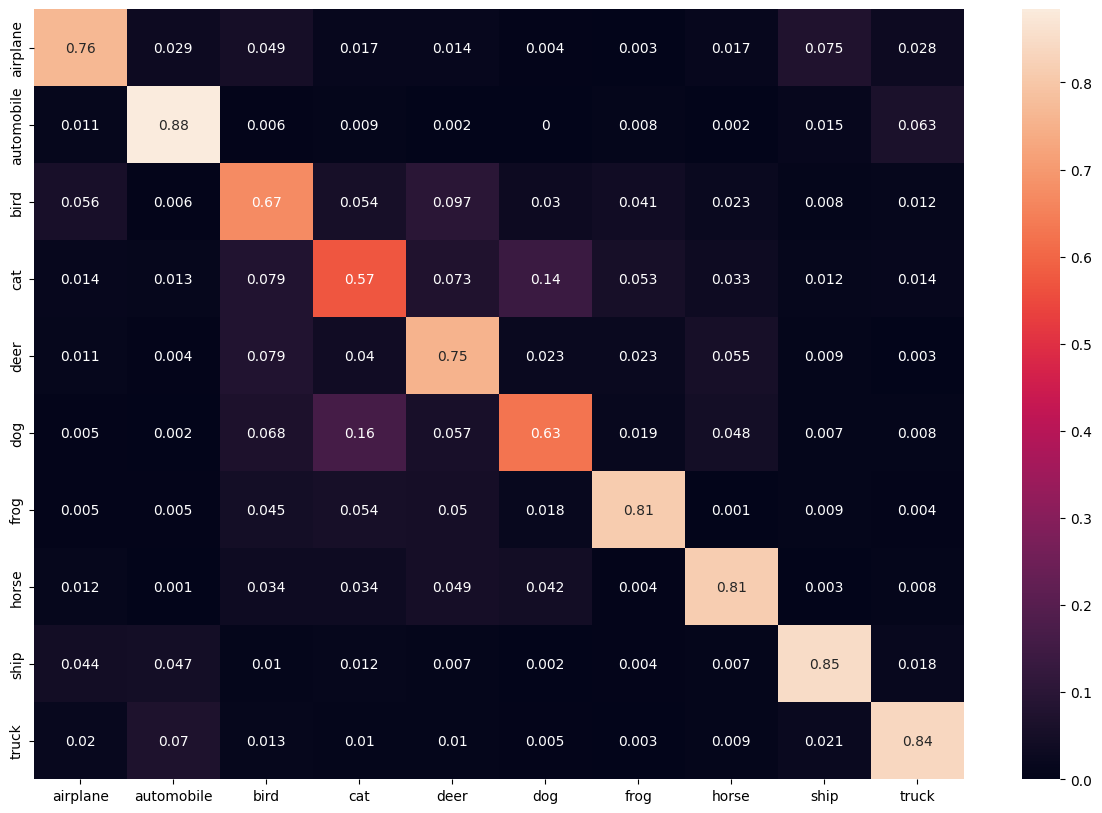

In [43]:
# recall for each category
cf = np.array(confusion_matrix)
norm_cf = cf / cf.astype(float).sum(axis=1)

plt.figure(figsize=(15, 10))
cf_dataframe = pd.DataFrame(np.array(norm_cf, dtype='float64'), index=test_data.classes, columns=test_data.classes).astype(float)
heatmap = sns.heatmap(cf_dataframe, annot=True)
plt.show()

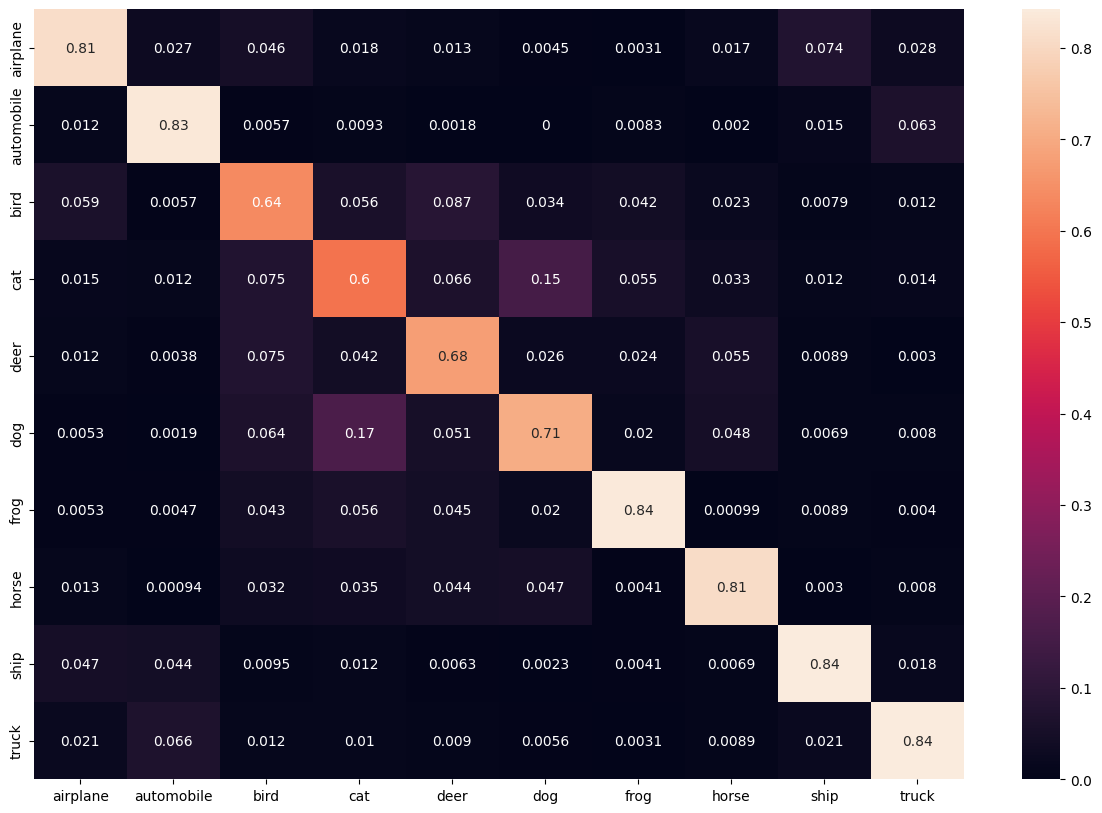

In [44]:
# acc for each category
cf = np.array(confusion_matrix)
norm_cf = cf / cf.astype(float).sum(axis=0)

plt.figure(figsize=(15, 10))
cf_dataframe = pd.DataFrame(np.array(norm_cf, dtype='float64'), index=test_data.classes, columns=test_data.classes).astype(float)
heatmap = sns.heatmap(cf_dataframe, annot=True)
plt.show()

In [45]:
# 样本模拟训练
def imshow(img):
    img = img / 2 + .05 # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [46]:
test_data = CIFAR10(root="cifar", train=False, transform=transforms.ToTensor())
classes = test_data.classes

In [47]:
def sample_predictions(n=4):
    test_dataloader = DataLoader(test_data, batch_size=n, shuffle=True, num_workers=0)
    dataiter = iter(test_dataloader)
    images, labels = dataiter.next()

    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

    imshow(make_grid(images))
    print('[Ground Truth | Predicted]:\n', ' '.join(f'[{classes[labels[j]]:5s} | {classes[predicted[j]]:5s}]\n' for j in range(n)))

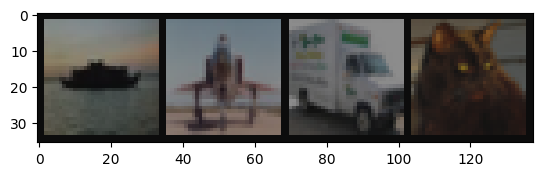

[Ground Truth | Predicted]:
 [ship  | ship ]
 [airplane | ship ]
 [truck | truck]
 [cat   | cat  ]



In [50]:
sample_predictions()